In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
import PIL
import cv2
import matplotlib.pyplot as plt

# pretrained model converting

In [2]:
# pretrained 모델의 load에 필요한 부분
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=3,
                 epsilon=1e-9,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = tf.keras.initializers.get(beta_initializer)
        self.gamma_initializer = tf.keras.initializers.get(gamma_initializer)
        self.beta_regularizer = tf.keras.regularizers.get(beta_regularizer)
        self.gamma_regularizer = tf.keras.regularizers.get(gamma_regularizer)
        self.beta_constraint = tf.keras.constraints.get(beta_constraint)
        self.gamma_constraint = tf.keras.constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = tf.keras.layers.InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = tf.keras.backend.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = tf.keras.backend.mean(inputs, reduction_axes, keepdims=True)
        stddev = tf.keras.backend.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = tf.keras.backend.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = tf.keras.backend.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': tf.keras.initializers.serialize(self.beta_initializer),
            'gamma_initializer': tf.keras.initializers.serialize(self.gamma_initializer),
            'beta_regularizer': tf.keras.regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': tf.keras.regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': tf.keras.constraints.serialize(self.beta_constraint),
            'gamma_constraint': tf.keras.constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# ref: https://stackoverflow.com/a/53349976/2447655
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        if s[1] == None:
            return (None, None, None, s[3])
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

    def get_config(self):
        config = super(ReflectionPadding2D, self).get_config()
        print(config)
        return config

def conv_layer(style, name, filters, kernel_size, strides=(1, 1), bias=True):
    init_weight = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.weight.npy")
    init_weight = np.transpose(init_weight, [2, 3, 1, 0])
    init_bias = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.bias.npy")

    if bias:
        bias_initializer = tf.keras.initializers.constant(init_bias)
    else:
        bias_initializer = "zeros"

    layer = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        kernel_initializer=tf.keras.initializers.constant(init_weight),
        bias_initializer=bias_initializer
    )
    return layer


def instance_norm_layer(style, name, epsilon=1e-9):
    init_beta = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.shift.npy")
    init_gamma = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.scale.npy")

    layer = InstanceNormalization(
        axis=-1,
        epsilon=epsilon,
        beta_initializer=tf.keras.initializers.Constant(init_beta),
        gamma_initializer=tf.keras.initializers.Constant(init_gamma)
    )
    return layer


def deconv_layers(style, name, filters, kernel_size, strides=(1, 1)):
    init_weight = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.weight.npy")
    init_weight = np.transpose(init_weight, [2, 3, 1, 0])
    init_bias = np.load(f"{PRETRAINED_WEIGHT_DIR}/{style}/{name}.bias.npy")

    layers = list()
    layers.append(tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        kernel_initializer=tf.keras.initializers.constant(init_weight),
        bias_initializer=tf.keras.initializers.constant(init_bias)
    ))

    layers.append(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))
    return layers


def load_model(style):
    inputs = tf.keras.Input(shape=(None, None, 3))

    # y = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(inputs)
    y = ReflectionPadding2D(padding=(3, 3))(inputs)
    y = conv_layer(style, "conv01_1", filters=64, kernel_size=7)(y)
    y = instance_norm_layer(style, "in01_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv02_1", filters=128, kernel_size=3, strides=(2, 2))(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv02_2", filters=128, kernel_size=3, strides=(1, 1))(y)
    y = instance_norm_layer(style, "in02_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv03_1", filters=256, kernel_size=3, strides=(2, 2))(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "conv03_2", filters=256, kernel_size=3, strides=(1, 1))(y)
    y = instance_norm_layer(style, "in03_1")(y)

    t_prev = tf.keras.layers.Activation("relu")(y)

    for i in range(4, 12):
        # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(t_prev)
        y = ReflectionPadding2D(padding=(1, 1))(t_prev)
        y = conv_layer(style, "conv%02d_1" % i, filters=256, kernel_size=3)(y)
        y = instance_norm_layer(style, "in%02d_1" % i)(y)
        y = tf.keras.layers.Activation("relu")(y)

        t = ReflectionPadding2D(padding=(1, 1))(y)
        t = conv_layer(style, "conv%02d_2" % i, filters=256, kernel_size=3)(t)
        t = instance_norm_layer(style, "in%02d_2" % i)(t)

        t_prev = tf.keras.layers.Add()([t, t_prev])

        if i == 11:
            y = t_prev

    layers = deconv_layers(style, "deconv01_1", filters=128, kernel_size=3, strides=(2, 2))
    for layer in layers:
        y = layer(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "deconv01_2", filters=128, kernel_size=3)(y)
    y = instance_norm_layer(style, "in12_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    layers = deconv_layers(style, "deconv02_1", filters=64, kernel_size=3, strides=(2, 2))
    for layer in layers:
        y = layer(y)
    # y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = ReflectionPadding2D(padding=(1, 1))(y)
    y = conv_layer(style, "deconv02_2", filters=64, kernel_size=3)(y)
    y = instance_norm_layer(style, "in13_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    # y = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(y)
    y = ReflectionPadding2D(padding=(3, 3))(y)
    y = conv_layer(style, "deconv03_1", filters=3, kernel_size=7)(y)
    y = tf.keras.layers.Activation("tanh")(y)

    model = tf.keras.Model(inputs=inputs, outputs=y)

    return model

In [3]:
# 기존 모델 불러와서 h5로 저장
PRETRAINED_WEIGHT_DIR = '/content/drive/MyDrive/final_project_sjh/CartoonGan-tensorflow_1/style_transfer/cartoongan/pretrained_weights'
styles = ["shinkai", "hayao", "hosoda", "paprika"]
h5_path = '/content/drive/MyDrive/final_project_sjh'
# STYLES = ["shinkai", "hayao", "hosoda", "paprika"]
for style in styles:
  model = load_model(style)
  tf.keras.models.save_model(model, f'{h5_path}/{style}.h5')

{'name': 'reflection_padding2d', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_1', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_2', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_3', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_4', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_5', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_6', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_7', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_8', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_9', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_10', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_11', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_12', 'trainable': True, 'dtype': 'float32'}
{'name': 'reflection_padding2d_13', '

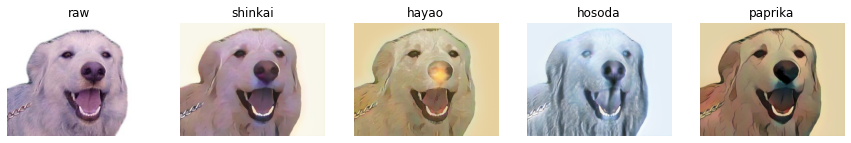

In [11]:
# 저장된 h5 파일 로드 후 결과 확인
image_path = '/content/drive/MyDrive/final_project_sjh/Semantic_segmentation/result.jpg'
input_image = cv2.imread(image_path)
input_image = np.expand_dims(input_image, axis=0)
i = 1
plt.figure(figsize=(15,10))
ax = plt.subplot(1,5,1)
ax.imshow(input_image[0])
ax.set_title('raw')
ax.axis('off')

for style in styles:
  model= tf.keras.models.load_model(f'/content/drive/MyDrive/final_project_sjh/h5_path/{style}.h5',custom_objects={'ReflectionPadding2D':ReflectionPadding2D,'InstanceNormalization':InstanceNormalization})
  output_image = model.predict(input_image)
  output_image = output_image[0]
  output_image = output_image[:,:,[2,1,0]]
  output_image = output_image * 0.5 + 0.5
  ax = plt.subplot(1,5,i+1)
  ax.imshow(output_image)
  ax.set_title(f'{style}')
  ax.axis('off')
  i += 1